In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd
import time
import pickle
from pathlib import Path
import re
from model_1p7 import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='whitegrid', rc={"font.family": "DejaVu Serif"})

# Debug

In [2]:
df, dff, dfp, sim, net = simulate(2, 'V', 0, 13, 80, 'random')

trial 1
trial 10
trial 20
trial 30
trial 40
trial 50
trial 60
trial 70
trial 80
running perturbations


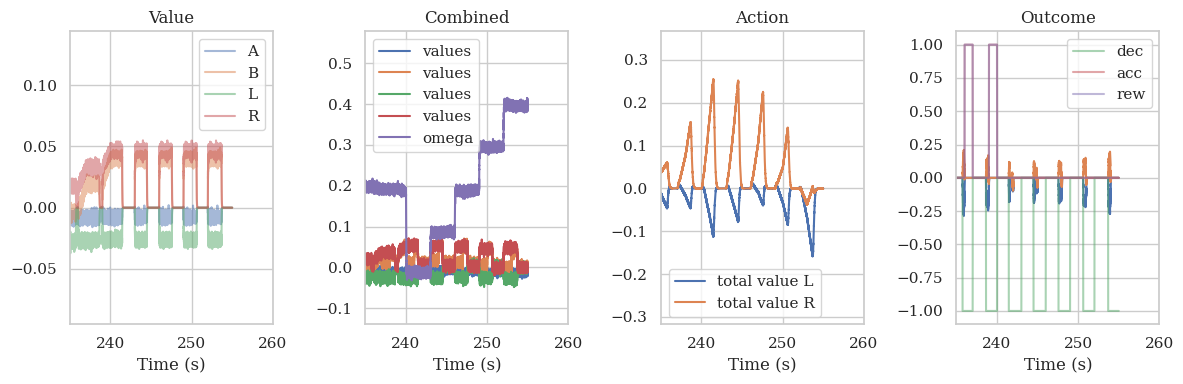

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, figsize=(12,4))
axes[0].plot(sim.trange(), sim.data[net.p_v][:,0], label='A', alpha=0.5)
axes[0].plot(sim.trange(), sim.data[net.p_v][:,1], label='B', alpha=0.5)
axes[0].plot(sim.trange(), sim.data[net.p_v][:,2], label='L', alpha=0.5)
axes[0].plot(sim.trange(), sim.data[net.p_v][:,3], label='R', alpha=0.5)
axes[1].plot(sim.trange(), sim.data[net.p_vwa][:,:4], label='values')
axes[1].plot(sim.trange(), sim.data[net.p_vwa][:,4], label='omega')
# axes[2].plot(sim.trange(), sim.data[net.p_vwa][:,4], label='vwa')
# axes[2].plot(sim.trange(), sim.data[net.p_vwa2][:,0], label='aL')
# axes[2].plot(sim.trange(), sim.data[net.p_vwa2][:,1], label='aR')
# axes[2].plot(sim.trange(), sim.data[net.p_w])
axes[2].plot(sim.trange(), sim.data[net.p_a][:,0], label='total value L')
axes[2].plot(sim.trange(), sim.data[net.p_a][:,1], label='total value R')
# axes[2].plot(sim.trange(), sim.data[net.p_thr], label='threshold')
axes[3].plot(sim.trange(), sim.data[net.p_ch])
axes[3].plot(sim.trange(), sim.data[net.p_dec][:,0], label='dec', alpha=0.5)
# axes[3].plot(sim.trange(), sim.data[net.p_dec][:,2], label='rt')
axes[3].plot(sim.trange(), sim.data[net.p_rew][:,3], label='acc', alpha=0.5)
axes[3].plot(sim.trange(), sim.data[net.p_rew][:,0], label='rew', alpha=0.5)
# axes[3].plot(sim.trange(), sim.data[net.p_ew])
# axes[3].plot(sim.trange(), sim.data[net.p_mask_learn])
axes[0].set(xlim=[235,260])
axes[0].set(title='Value', xlabel="Time (s)")  # : 1s ITI, 1s Cue, 1s Rew
axes[1].set(title='Combined', xlabel="Time (s)")
axes[2].set(title='Action', xlabel="Time (s)")
axes[3].set(title='Outcome', xlabel="Time (s)")
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout()
plt.show()
# fig.savefig("plots/dynamics_2.jpg", dpi=600)

In [5]:
pd.read_pickle("data/nef/1_V_0_1_pert.pkl")

,seed,monkey,session,block,trial,va,vb,vl,vr,w,...,vwa_r,vwa_w,al,ar,dec,tdec,thr,rew,acc,pert
0,1,V,0,1,80,0.167925,-0.037352,0.086694,0.073675,0.647687,...,0.078239,0.654149,-0.036215,0.346848,-1.0,0.419,0.34720,0.0,0.0,-0.2
1,1,V,0,1,80,0.168420,-0.034301,0.084502,0.078176,0.749403,...,0.083503,0.755130,0.008582,0.345017,-1.0,0.474,0.30100,0.0,0.0,-0.1
2,1,V,0,1,80,0.167189,-0.039278,0.086120,0.082269,0.847979,...,0.081239,0.845553,-0.040069,0.339319,-1.0,0.429,0.33880,0.0,0.0,0.0
3,1,V,0,1,80,0.164639,-0.039793,0.084566,0.081707,0.950139,...,0.079018,0.936514,-0.051638,0.323265,-1.0,0.438,0.33124,0.0,0.0,0.1
4,1,V,0,1,80,0.162121,-0.034393,0.085405,0.075771,1.009551,...,0.074868,0.992007,-0.064752,0.329823,-1.0,0.415,0.35056,0.0,0.0,0.2


# Plotting

In [73]:
def adjust_df(df, do_acc=True, do_delta=False):
    if do_acc: df['acc'] = df['acc'].replace(-1, 0)
    emp = pd.read_pickle("data/empirical2.pkl")
    block_starts = emp[emp['trial'] == 1].copy()
    if do_delta:
        df['dv_let'] = df['vwa_a'] - df['vwa_b']
        df['dv_loc'] = df['vwa_l'] - df['vwa_r']
    
    def classify(row):
        b = row['block']
        if 1 <= b <= 12:
            # Letter blocks: check if it starts with A or B
            start = row['cor_let']
            return f"let_{start}{'B' if start == 'A' else 'A'}"
        elif 13 <= b <= 24:
            # Location blocks: check if starts with left or right
            start_init = 'L' if row['cor_loc'] == 'left' else 'R'
            end_init = 'R' if start_init == 'L' else 'L'
            return f"loc_{start_init}{end_init}"
        return "unknown"

    block_starts['block_label'] = block_starts.apply(classify, axis=1)
    
    # Create a mapping dictionary {block_number: label}
    block_type_map = block_starts.set_index('block')['block_label'].to_dict()
    
    # 4. Apply labels to the main dataframe
    df['block_type'] = df['block'].map(block_type_map)
    
    # block_mapping = emp[['block', 'block_type']].drop_duplicates().set_index('block')['block_type']
    # df['block_type'] = df['block'].map(block_mapping)
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    join_keys = ['monkey', 'session', 'block', 'trial']
    extra_cols = ['rev', 'cor_let', 'cor_loc']
    df = df.merge(emp[join_keys + extra_cols], on=join_keys, how='left')
    return df

In [3]:
def plot_values(nef_data, x='rev'):
    target_blocks = ['loc_RL', 'loc_LR', 'let_AB', 'let_BA']
    pretty_labels = {
        'let_AB': 'What\nA \u2192 B',
        'let_BA': 'What\nB \u2192 A',
        'loc_LR': 'Where\nL \u2192 R',
        'loc_RL': 'Where\nR \u2192 L'
    }
    name_map = {'va': 'A', 'vb': 'B', 'vl': 'L', 'vr': 'R'}
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 5), sharex=True, sharey="col")
    titles = ['Values', r"$\omega$", 'RT']
    columns_to_plot = [['va', 'vb', 'vl', 'vr'], ['w'], ['tdec']]
    for row_idx, b_type in enumerate(target_blocks):
        df = nef_data[nef_data['block_type'] == b_type].copy()
        if df.empty: continue
        for col_idx, cols in enumerate(columns_to_plot):
            ax = axes[row_idx, col_idx]
            plot_df = df.query("rev != 0")
            for metric in cols:
                label_name = name_map.get(metric, metric)
                sns.lineplot(data=plot_df, x=x, y=metric, ax=ax, label=label_name)
            ax.axvline(0, color='black', linestyle='--', alpha=0.3)
            ax.set(xlim=[-45, 45], xticks=[-40, 0, 40], ylabel=None)
            ax.xaxis.grid(False)
            if col_idx == 0:
                ax.set_ylabel(pretty_labels.get(b_type, b_type), rotation=0, labelpad=40, verticalalignment='center')
            if col_idx==0 and row_idx==0:
                ax.legend(ncol=2)
            else:
                if ax.get_legend(): ax.get_legend().remove()
            if row_idx == 0:
                ax.set_title(titles[col_idx], fontweight='bold', pad=20)
            if row_idx == len(target_blocks)-1:
                ax.set(xlabel="Trial (reversal)")
    plt.tight_layout()
    plt.show()
    fig.savefig("plots/values.pdf")
    fig.savefig("plots/values.jpg", dpi=600)

In [4]:
def plot_performance_omega(nef_data, rl_data, label, window_size=7, x_ratio=0.7):
    emp = pd.read_pickle("data/empirical2.pkl")
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    type_map = {'let_AB': 'what', 'let_BA': 'what', 'loc_LR': 'where', 'loc_RL': 'where'}
    for i, dataset in enumerate([emp, nef_data, rl_data]):
        dataset['super_type'] = dataset['block_type'].map(type_map).fillna(dataset['block_type'])
        dataset['after_rev'] = dataset['rev'] >= 0
        if i<2:
            target_col = 'monkey_accuracy' if 'monkey_accuracy' in dataset.columns else 'acc'
            dataset['smoothed_acc'] = dataset.groupby(['monkey', 'super_type', 'session', 'block', 'after_rev'])[target_col].transform(lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean())

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 4), sharex=True,  sharey='row', gridspec_kw={'height_ratios': [x_ratio, 1 - x_ratio]})
    
    sns.lineplot(data=emp, x='rev', y='smoothed_acc', hue='super_type', hue_order=['what', 'where'], ax=axes[0][0])
    axes[0][0].set_title('Empirical Data')
    axes[0][0].set(xlim=[-45, 45], ylabel='Task Performance', ylim=[0, 1])
    axes[0][0].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[0][0].legend(title='Block Type')
    axes[0][0].xaxis.grid(False)  # Explicitly disable vertical lines

    sns.lineplot(data=nef_data, x='rev', y='smoothed_acc', hue='super_type', hue_order=['what', 'where'], ax=axes[0][1])
    axes[0][1].set_title(f'NEF Model ({label})')
    # axes[0][1].set(xlabel='Trial Relative to Reversal', ylim=[0, 1])
    axes[0][1].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[0][1].get_legend().remove()
    axes[0][1].xaxis.grid(False)  # Explicitly disable vertical lines

    sns.lineplot(data=rl_data, x='rev', y='omega', hue='super_type', hue_order=['what', 'where'], ax=axes[1][0])
    axes[1][0].set(xlabel='Trial Relative to Reversal', ylabel=r"Decoded $\omega$", ylim=[0, 1])
    axes[1][0].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[1][0].get_legend().remove()
    axes[1][0].xaxis.grid(False)  # Explicitly disable vertical lines

    sns.lineplot(data=nef_data, x='rev', y='w', hue='super_type', hue_order=['what', 'where'], ax=axes[1][1])
    axes[1][1].set(xlabel='Trial Relative to Reversal', ylim=[0, 1])
    axes[1][1].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[1][1].get_legend().remove()
    axes[1][1].xaxis.grid(False)  # Explicitly disable vertical lines

    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/performance_omega_{label}.pdf")
    fig.savefig(f"plots/performance_omega_{label}.jpg", dpi=600)

In [5]:
def plot_control_inhibited(control, inhibited, rl_data, window_size=7, x_ratio=0.7):
    emp = pd.read_pickle("data/empirical2.pkl")
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    type_map = {'let_AB': 'what', 'let_BA': 'what', 'loc_LR': 'where', 'loc_RL': 'where'}
    control['perturbation'] = 'control'
    inhibited['perturbation'] = 'inhibited'
    nef_data = pd.concat([control, inhibited], ignore_index=True)
    for i, dataset in enumerate([emp, nef_data, rl_data]):
        dataset['block type'] = dataset['block_type'].map(type_map).fillna(dataset['block_type'])
        dataset['after_rev'] = dataset['rev'] >= 0
        if i<2:
            target_col = 'monkey_accuracy' if 'monkey_accuracy' in dataset.columns else 'acc'
            dataset['smoothed_acc'] = dataset.groupby(['monkey', 'block type', 'session', 'block', 'after_rev'])[target_col].transform(lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean())

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 4), sharex=True,  sharey='row', gridspec_kw={'height_ratios': [x_ratio, 1 - x_ratio]})
    
    sns.lineplot(data=emp, x='rev', y='smoothed_acc', hue='block type', hue_order=['what', 'where'], ax=axes[0][0])
    axes[0][0].set_title('Empirical Data')
    axes[0][0].set(xlim=[-45, 45], ylabel='Task Performance', ylim=[0, 1])
    axes[0][0].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[0][0].get_legend().remove()
    axes[0][0].xaxis.grid(False)  # Explicitly disable vertical lines

    sns.lineplot(data=nef_data, x='rev', y='smoothed_acc', hue='block type', hue_order=['what', 'where'], style='perturbation', ax=axes[0][1])
    axes[0][1].set_title('NEF Data')
    # axes[0][1].set(xlabel='Trial Relative to Reversal', ylim=[0, 1])
    axes[0][1].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[0][1].get_legend().remove()
    axes[0][1].xaxis.grid(False)  # Explicitly disable vertical lines
    axes[0][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    sns.lineplot(data=rl_data, x='rev', y='omega', hue='block type', hue_order=['what', 'where'], ax=axes[1][0])
    axes[1][0].set(xlabel='Trial Relative to Reversal', ylabel=r"Decoded $\omega$", ylim=[0, 1])
    axes[1][0].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[1][0].get_legend().remove()
    axes[1][0].xaxis.grid(False)  # Explicitly disable vertical lines

    sns.lineplot(data=nef_data, x='rev', y='w', hue='block type', hue_order=['what', 'where'], style='perturbation', ax=axes[1][1])
    axes[1][1].set(xlabel='Trial Relative to Reversal', ylim=[0, 1])
    axes[1][1].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[1][1].get_legend().remove()
    axes[1][1].xaxis.grid(False)  # Explicitly disable vertical lines

    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/control_vs_inhibited.pdf")
    fig.savefig(f"plots/control_vs_inhibited.jpg", dpi=600)

In [6]:
def plot_control_pos_neg(control, pos, neg, rl_data, window_size=7, x_ratio=0.7):
    emp = pd.read_pickle("data/empirical2.pkl")
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    type_map = {'let_AB': 'what', 'let_BA': 'what', 'loc_LR': 'where', 'loc_RL': 'where'}
    control['perturbation'] = 'control'
    pos['perturbation'] = 'positive'
    neg['perturbation'] = 'negative'
    nef_data = pd.concat([control, pos, neg], ignore_index=True)
    for i, dataset in enumerate([emp, nef_data, rl_data]):
        dataset['block type'] = dataset['block_type'].map(type_map).fillna(dataset['block_type'])
        dataset['after_rev'] = dataset['rev'] >= 0
        if i<2:
            target_col = 'monkey_accuracy' if 'monkey_accuracy' in dataset.columns else 'acc'
            dataset['smoothed_acc'] = dataset.groupby(['monkey', 'block type', 'session', 'block', 'after_rev'])[target_col].transform(lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean())

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 4), sharex=True,  sharey='row', gridspec_kw={'height_ratios': [x_ratio, 1 - x_ratio]})

    sns.lineplot(data=emp, x='rev', y='smoothed_acc', hue='block type', hue_order=['what', 'where'], ax=axes[0][0])
    axes[0][0].set_title('Empirical Data')
    axes[0][0].set(xlim=[-45, 45], ylabel='Task Performance', ylim=[0, 1])
    axes[0][0].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[0][0].get_legend().remove()
    axes[0][0].xaxis.grid(False)  # Explicitly disable vertical lines

    sns.lineplot(data=nef_data, x='rev', y='smoothed_acc', hue='block type', hue_order=['what', 'where'], style='perturbation', ax=axes[0][1])
    axes[0][1].set_title('NEF Data')
    # axes[0][1].set(xlabel='Trial Relative to Reversal', ylim=[0, 1])
    axes[0][1].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[0][1].get_legend().remove()
    axes[0][1].xaxis.grid(False)  # Explicitly disable vertical lines
    axes[0][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    sns.lineplot(data=rl_data, x='rev', y='omega', hue='block type', hue_order=['what', 'where'], ax=axes[1][0])
    axes[1][0].set(xlabel='Trial Relative to Reversal', ylabel=r"Decoded $\omega$", ylim=[0, 1])
    axes[1][0].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[1][0].get_legend().remove()
    axes[1][0].xaxis.grid(False)  # Explicitly disable vertical lines

    sns.lineplot(data=nef_data, x='rev', y='w', hue='block type', hue_order=['what', 'where'], style='perturbation', ax=axes[1][1])
    axes[1][1].set(xlabel='Trial Relative to Reversal', ylim=[0, 1])
    axes[1][1].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[1][1].get_legend().remove()
    axes[1][1].xaxis.grid(False)  # Explicitly disable vertical lines

    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/control_vs_posneg.pdf")
    fig.savefig(f"plots/control_vs_posneg.jpg", dpi=600)

# Perturbation during training

In [76]:
control = adjust_df(pd.read_pickle("data/nef/control/nef_data.pkl.xz"))
pert = adjust_df(pd.read_pickle("data/nef/nef_data.pkl.xz")).query("pert==0.0")
inh = adjust_df(pd.read_pickle("data/nef/inh/nef_data.pkl.xz"))
pos = adjust_df(pd.read_pickle("data/nef/pos/nef_data.pkl.xz"))
neg = adjust_df(pd.read_pickle("data/nef/neg/nef_data.pkl.xz"))
rl = adjust_df(pd.read_pickle("data/rl_values.pkl"), False, False)

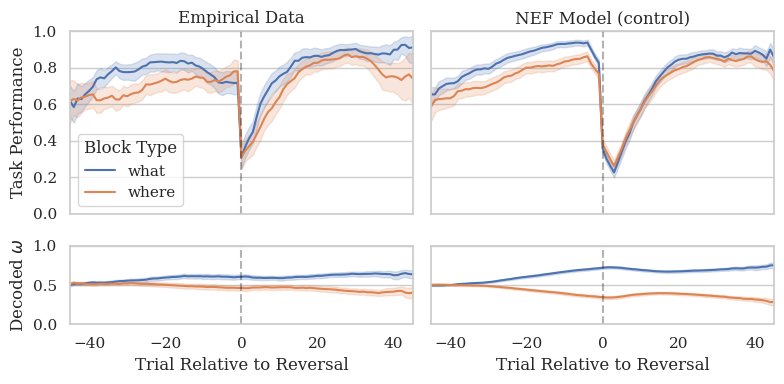

In [49]:
plot_performance_omega(control, rl, label='control')

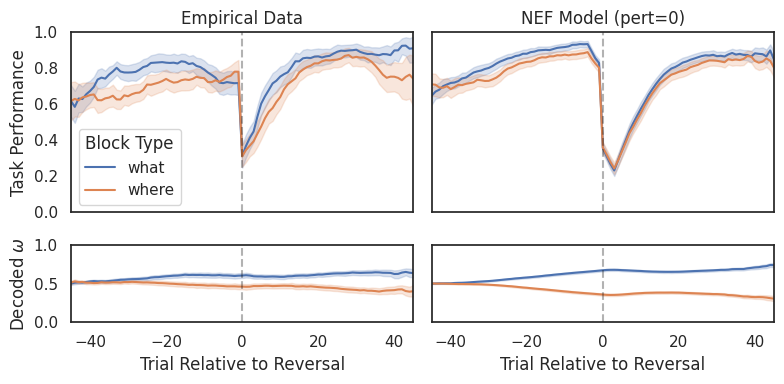

In [77]:
plot_performance_omega(pert, rl, label='pert=0')

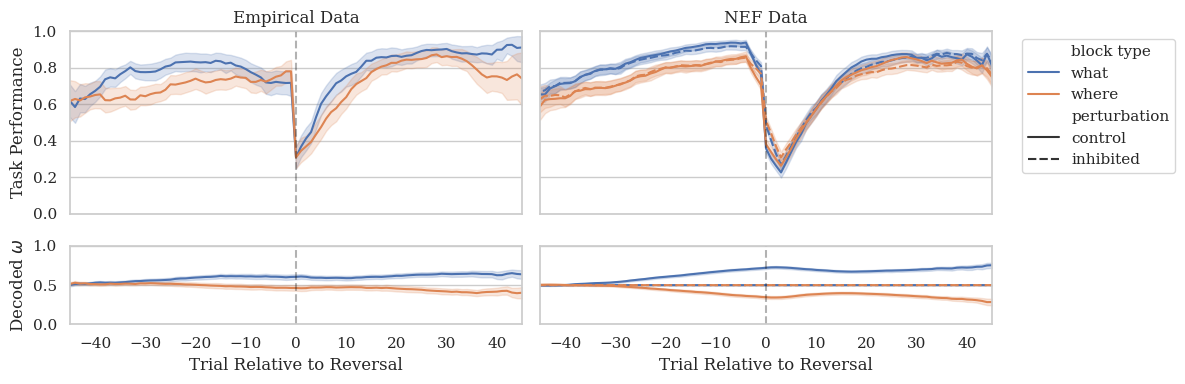

In [50]:
plot_control_inhibited(control, inh, rl)

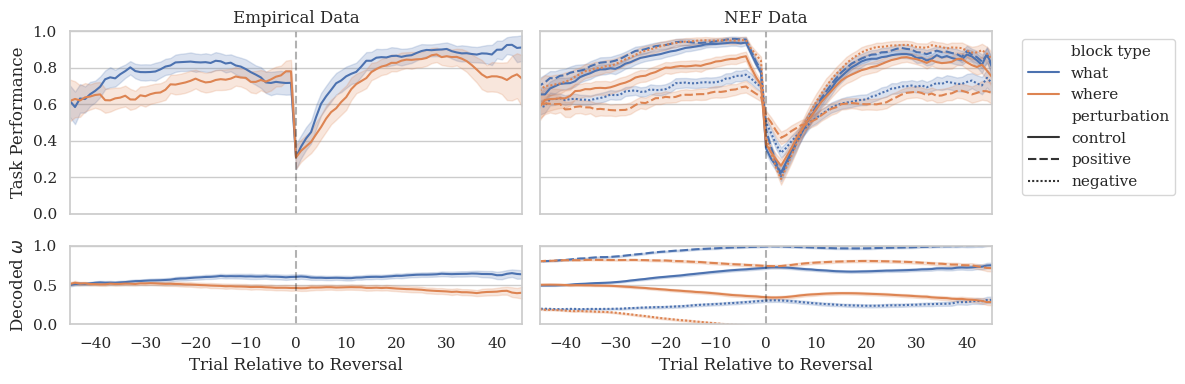

In [56]:
plot_control_pos_neg(control, pos, neg, rl)

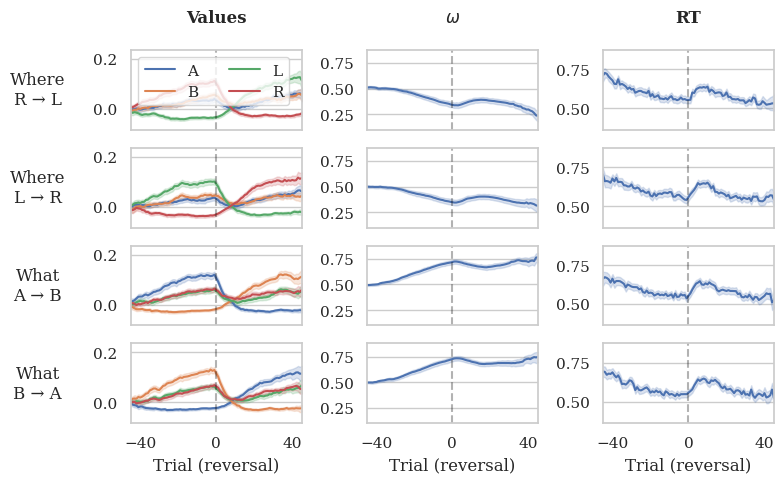

In [33]:
plot_values(control)

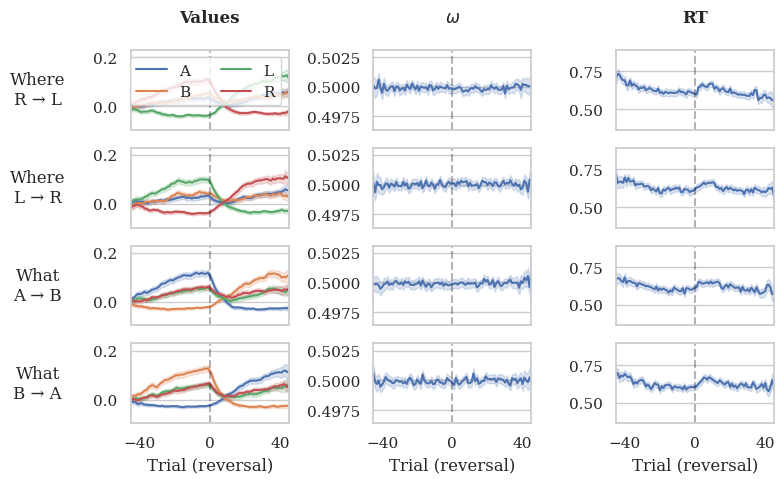

In [57]:
plot_values(inh)

# Ramping

In [51]:
def load_adjust_full(df):
    df['acc'] = df['acc'].replace(-1, 0)
    df['trial'] = (np.floor(df['time'] / 3.0) + 1).astype(int)
    emp = pd.read_pickle("data/empirical2.pkl")
    emp_subset = emp[['monkey', 'session', 'block', 'trial', 'cor_loc', 'cor_let', 'block_type', 'reversal_at_trial']].drop_duplicates()
    join_keys = ['monkey', 'session', 'block', 'trial']
    df = df.merge(emp_subset, on=join_keys, how='left')
    df['rev'] = df['trial'] - df['reversal_at_trial']
    is_left = (df['cor_loc'] == 'left')
    df['acor'] = np.where(is_left, df['al'], df['ar'])
    df['ainc'] = np.where(is_left, df['ar'], df['al'])
    df['t_since_cue'] = df['time'] % 3.0 - 1.0
    df['da'] = df['acor'] - df['ainc']
    for col in ['monkey', 'block_type', 'cor_loc', 'cor_let']:
        df[col] = df[col].astype('category')
    return df

In [52]:
def plot_ramp(df, label, trial_start=38, trial_end=45):
    df = df.query("@trial_start <= rev < @trial_end").copy()
    type_map = {'what': 'What Blocks', 'where': 'Where Blocks'}
    df['super_type'] = df['block_type'].map(type_map)
    categories = ['Where Blocks', 'What Blocks']
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True, sharex=True)
    for i, cat in enumerate(categories):
        data_subset = df[df['super_type'] == cat]
        sns.lineplot(data=data_subset, x='t_since_cue', y='da', ax=axes[i], color=palette[0], alpha=1)
        # sns.lineplot(data=data_subset, x='t_since_cue', y='acor', ax=axes[i], color=palette[1], alpha=0.3, label='a correct')
        # sns.lineplot(data=data_subset, x='t_since_cue', y='ainc', ax=axes[i], color=palette[2], alpha=0.3, label='a incorrect')
        # sns.lineplot(data=data_subset, x='t_since_cue', y='thr', ax=axes[i], color=palette[3], alpha=0.3, label='a thr')
        axes[i].set_title(cat+f" ({label})", fontweight='bold', fontsize=14)
        axes[i].set(xlabel='Time from Cue (s)', ylabel="Action Value\n(v correct - v incorrect)" if i == 0 else None)
        axes[i].axvline(0, color='black', linestyle='--', alpha=0.3)
        axes[i].set_xticks(np.linspace(-1,1,5))
        axes[i].set_xlim([-1, 1])
    # axes[0].set(ylim=[0,0.7])
    # axes[1].set(ylim=[0,0.2], yticks=[0.0, 0.05, 0.1, 0.15, 0.2])
    # axes[0].legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/ramp_{label}.pdf")
    fig.savefig(f"plots/ramp_{label}.jpg", dpi=600)

In [53]:
control_full = load_adjust_full(pd.read_pickle("data/nef/control/nef_data_full.pkl.xz"))
inh_full = load_adjust_full(pd.read_pickle("data/nef/inh/nef_data_full.pkl.xz"))
pos_full = load_adjust_full(pd.read_pickle("data/nef/pos/nef_data_full.pkl.xz"))
neg_full = load_adjust_full(pd.read_pickle("data/nef/neg/nef_data_full.pkl.xz"))

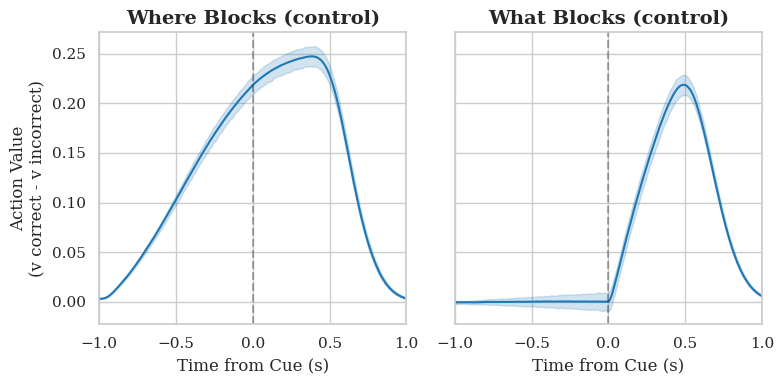

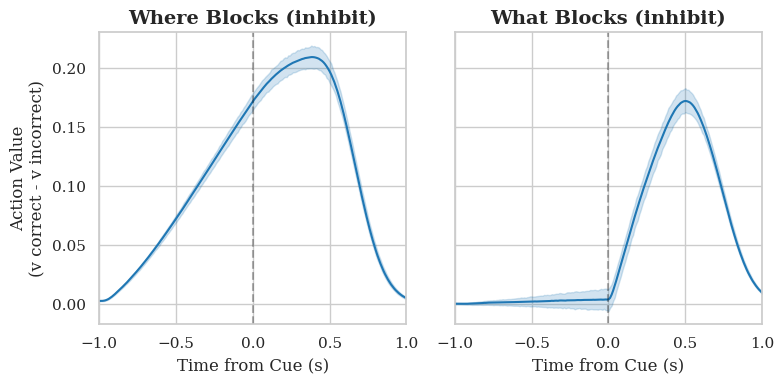

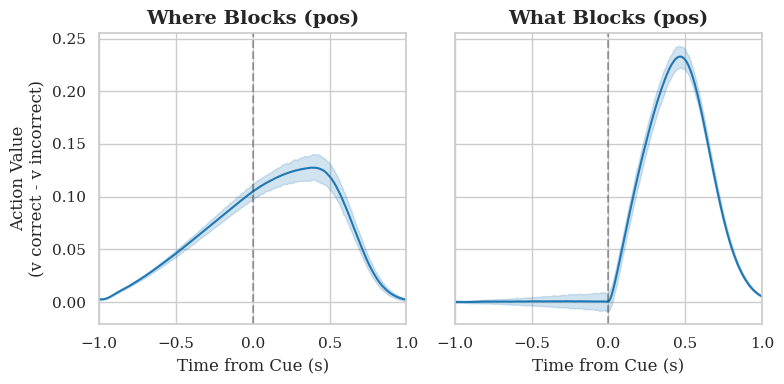

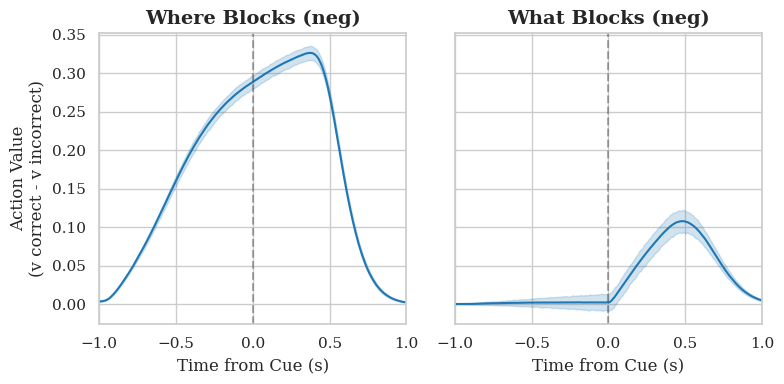

In [54]:
plot_ramp(control_full, "control")
plot_ramp(inh_full, "inhibit")
plot_ramp(pos_full, "pos")
plot_ramp(neg_full, "neg")

# Decoding DV_let and DV_loc under perturbation

In [27]:
pert = adjust_df(pd.read_pickle("data/nef/nef_data_pert.pkl.xz"))

In [38]:
def plot_dv_decoding(pert):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True, sharey=True)
    scatter_settings = {'alpha': 0.3, 's': 10}
    perts = [0.0, -0.1, -0.2, 0.1, 0.2]
    labels = ["control", "-0.1", "-0.2", "0.1", "0.2"]
    x_data = pert.query("pert==0.0")['dv_let']
    x_data2 = pert.query("pert==0.0")['dv_loc']
    for i, p in enumerate(perts):
        y_data = pert.query(f"pert=={p}")['dv_let']
        y_data2 = pert.query(f"pert=={p}")['dv_loc']
        sns.regplot(x=x_data, y=y_data, ax=axes[0], color=palette[i], label=labels[i], scatter_kws=scatter_settings)
        sns.regplot(x=x_data2, y=y_data2, ax=axes[1], color=palette[i], label=labels[i], scatter_kws=scatter_settings)
    axes[0].set(ylabel=r'$\Delta V_{let}$ (control)', xlabel=r'$\Delta V_{let}$ (perturbed)', xlim=[-0.4, 0.4], ylim=[-0.4, 0.4])
    axes[1].set(ylabel=r'$\Delta V_{loc}$ (control)', xlabel=r'$\Delta V_{loc}$ (perturbed)', xlim=[-0.4, 0.4], ylim=[-0.4, 0.4])
    axes[0].legend()
    plt.tight_layout()
    plt.show()

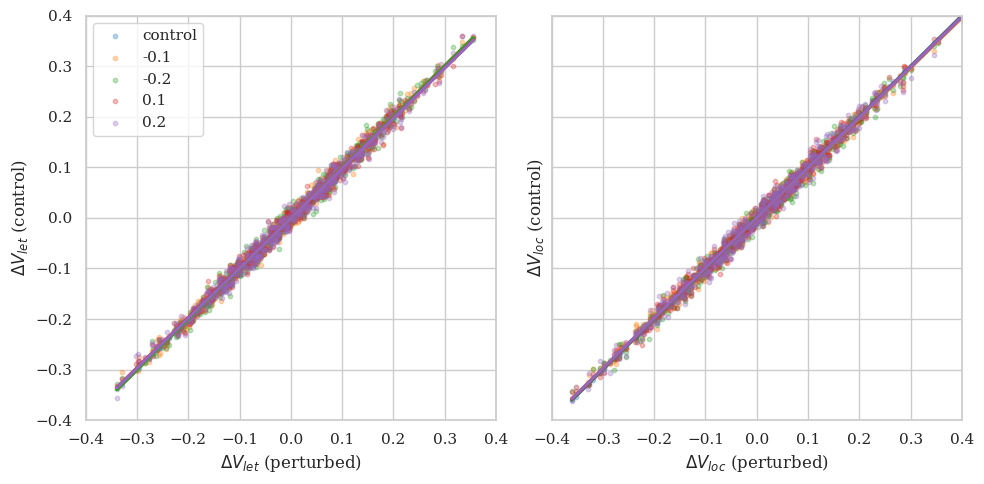

In [39]:
plot_dv_decoding(pert)

In [ ]:
def plot_action_offset(pert):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    perts = [0.0, -0.1, -0.2, 0.1, 0.2]
    labels = ["control", "-0.1", "-0.2", "0.1", "0.2"]
    y_true = pert.query("pert==0.0")['dv_let']
    for i, p in enumerate(perts):
        y_pert = pert.query(f"pert=={p}")['dec']
        delta_y = np.abs(y_pert - y_true)
        sns.regplot(x=x_data, y=y_data, ax=axes[0], color=palette[i], label=labels[i], scatter_kws=scatter_settings)
        sns.regplot(x=x_data2, y=y_data2, ax=axes[1], color=palette[i], label=labels[i], scatter_kws=scatter_settings)
    axes[0].set(ylabel=r'$\Delta V_{let}$ (control)', xlabel=r'$\Delta V_{let}$ (perturbed)', xlim=[-0.4, 0.4], ylim=[-0.4, 0.4])
    axes[1].set(ylabel=r'$\Delta V_{loc}$ (control)', xlabel=r'$\Delta V_{loc}$ (perturbed)', xlim=[-0.4, 0.4], ylim=[-0.4, 0.4])
    axes[0].legend()
    plt.tight_layout()
    plt.show()

In [68]:
def plot_error_probability(df):
    p2 = [palette[1], palette[2], palette[0], palette[3], palette[4]]
    df = df.copy()
    df['trial_id'] = df.groupby('pert').cumcount()
    pivot_df = df.pivot(index='trial_id', columns='pert', values='dec')
    results = []
    control_col = 0.0
    all_perts = sorted(pivot_df.columns) 
    for p in all_perts:
        is_different = (pivot_df[control_col] != pivot_df[p])
        prob_diff = is_different.mean()
        results.append({'Perturbation': p,'Percentage': prob_diff * 100})
    plot_df = pd.DataFrame(results)
    plt.figure(figsize=(8, 5))
    sns.set_style("white")
    ax = sns.barplot(data=plot_df, x='Perturbation', y='Percentage', hue='Perturbation', palette=p2)
    # ax.legend(title="Perturbation", loc='upper center')
    ax.get_legend().remove()
    for p_bar in ax.patches:
        height = p_bar.get_height()
        if height > 0:
            ax.annotate(f'{height:.1f}%', 
                    (p_bar.get_x() + p_bar.get_width() / 2., height), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=10, weight='bold')
    ax.set(ylabel="Percent of Trials Different (%)", xlabel="Perturbation Level ($w$)")
    current_max = plot_df['Percentage'].max()
    ax.set_ylim(0, max(current_max * 1.2, 10))
    sns.despine()
    plt.tight_layout()
    plt.show()

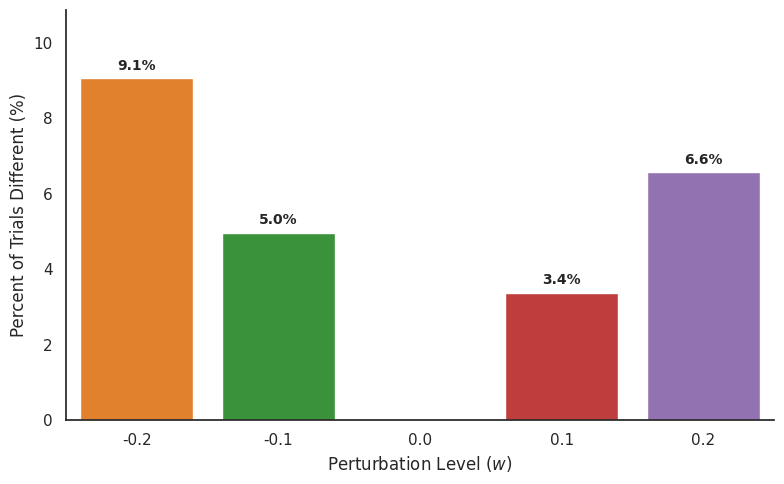

In [69]:
plot_error_probability(pert)